In [38]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting options
%matplotlib inline

csv_path = 'loan_stat542.csv'
loans = pd.read_csv(csv_path)
print("Shape of dataframe: ",loans.shape)
loans.sample(5)

Shape of dataframe:  (844006, 30)


,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
415366,43609340,33825,60 months,20.49,905.41,E,E4,Director of qa,2 years,RENT,...,669,8,0,14159.0,99.0,16,w,Individual,0.0,0.0
481127,9837806,9000,36 months,10.99,294.61,B,B2,Teacher,10+ years,MORTGAGE,...,704,17,0,10263.0,65.0,30,f,Individual,0.0,0.0
111501,20037141,18400,60 months,24.08,530.19,F,F2,Payroll Co-ordinator/Accountant,1 year,MORTGAGE,...,694,11,1,16740.0,77.1,19,w,Individual,1.0,0.0
492699,8275638,14000,60 months,15.61,337.56,C,C3,Senior investment accountant,< 1 year,RENT,...,699,8,0,21076.0,88.9,24,f,Individual,0.0,0.0
449964,39521484,7500,36 months,6.03,228.27,A,A1,Assistant Director of Purchasing,9 years,MORTGAGE,...,829,21,0,997.0,1.9,32,f,Individual,1.0,0.0


In [2]:
loans.columns.tolist()

['id',
 'loan_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'mort_acc',
 'pub_rec_bankruptcies']

Check the distribution of loan_status. If the status is fully paid, then the label is 0. If the status is default or charged off, then the labels are 1. 

In [3]:
loans['loan_status'].value_counts(dropna = False)

Fully Paid     673112
Charged Off    170822
Default            72
Name: loan_status, dtype: int64

### Exploratory data analysis conclusion:

1. ['term'] About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.
2. ['loan_amnt'] Charged-off loans tend to have higher loan amounts. 
3. ['int_rate'] Charged-off loans tend to have much higher interest rates.
4. ['annual_inc'] individuals with higher income are more likely to pay off their loans.
5. ['pub_rec_bankruptcies'] Individuals who pay off their loans are more likely to have several mortgage accounts.


Reference: https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data

In [4]:
# There are too many different job titles for this feature to be useful, so we drop it.
loans['emp_title'].describe()


count      793160
unique     274609
top       Teacher
freq        12275
Name: emp_title, dtype: object

In [5]:
# The grade is implied by the subgrade, so let's drop the grade column.
# the purpose variable appears to already contain this information. So we drop the title variable.
loans.drop('grade',axis = 1, inplace = True)
loans.drop('emp_title',axis = 1, inplace = True)
loans.drop('title', axis=1, inplace=True)
loans.drop(labels='zip_code', axis=1, inplace=True)
loans.drop('earliest_cr_line', axis=1, inplace=True)

In [6]:
# Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." 
# The actual data does not match this description:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        55277
10+ years    274730
2 years       76034
3 years       67265
4 years       50523
5 years       53949
6 years       41500
7 years       40519
8 years       39715
9 years       32767
< 1 year      67238
NaN           44489
Name: emp_length, dtype: int64

In [7]:
# Convert emp_length to integers
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)
loans['emp_length'].value_counts(dropna=False).sort_index()

 0.0      67238
 1.0      55277
 2.0      76034
 3.0      67265
 4.0      50523
 5.0      53949
 6.0      41500
 7.0      40519
 8.0      39715
 9.0      32767
 10.0    274730
NaN       44489
Name: emp_length, dtype: int64

In [8]:
# Replace the values ANY and NONE with OTHER:
# "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)
loans['home_ownership'].value_counts(dropna=False)


MORTGAGE    421628
RENT        335225
OWN          86868
OTHER          285
Name: home_ownership, dtype: int64

In [9]:
# Data Dictionary: "A category provided by the borrower for the loan request."
loans['purpose'].value_counts()

debt_consolidation    496197
credit_card           180491
home_improvement       53202
other                  47072
major_purchase         18440
small_business         10531
car                     9393
medical                 9388
moving                  6005
vacation                5401
house                   4666
wedding                 2273
renewable_energy         621
educational              326
Name: purpose, dtype: int64

In [10]:
# Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.122305
car                   0.143831
educational           0.171779
credit_card           0.175333
home_improvement      0.177418
major_purchase        0.179989
vacation              0.192742
house                 0.197814
other                 0.209169
debt_consolidation    0.213790
medical               0.223370
moving                0.238468
renewable_energy      0.244767
small_business        0.300066
Name: loan_status, dtype: float64

In [11]:
# Calculate the charge-off rates by address state:
# The charge-off rate ranges from 13.0% in Washington, DC to 27.6% in Mississippi.

loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
ME    0.125802
DC    0.128620
NH    0.139974
IA    0.142857
VT    0.143921
OR    0.150079
CO    0.154034
WA    0.162823
KS    0.168399
SC    0.168683
ID    0.172026
WI    0.172773
MT    0.173069
UT    0.174210
WY    0.175159
WV    0.179495
CT    0.180472
GA    0.187830
RI    0.189674
MA    0.190069
IL    0.190110
AZ    0.193777
CA    0.195138
TX    0.198375
HI    0.199008
DE    0.201630
AK    0.202063
VA    0.204023
MI    0.204923
MN    0.206965
NC    0.210555
MD    0.210806
PA    0.211016
KY    0.212292
NJ    0.212681
MO    0.215253
FL    0.217878
SD    0.220690
NM    0.221453
OH    0.221521
ND    0.222561
NY    0.223351
IN    0.223449
TN    0.224601
NV    0.229201
LA    0.235091
AR    0.239218
AL    0.243614
OK    0.244235
NE    0.252123
MS    0.268757
Name: loan_status, dtype: float64

In [12]:
#Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, 
# excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
loans['dti'].describe()


count    843910.000000
mean         17.883412
std           9.481892
min          -1.000000
25%          11.590000
50%          17.330000
75%          23.630000
max         999.000000
Name: dti, dtype: float64

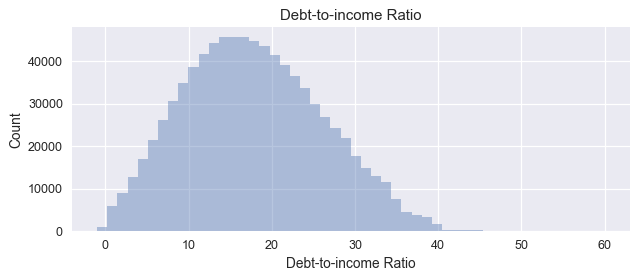

In [13]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [14]:
# Completed loans that are charged off tend to have higher debt-to-income ratios.

loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,170813.0,20.003621,9.254917,0.00,13.6000,19.75,26.21,999.00
Default,72.0,20.229722,8.523281,1.23,14.2875,19.98,27.80,44.48
Fully Paid,673025.0,17.345055,9.463425,-1.00,11.1800,16.76,22.92,999.00


In [15]:
# Check the Pearson correlation between these values:
loans[['fico_range_low','fico_range_high']].corr()


,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [16]:
# We only need to keep one of the FICO scores. We'll take the average of the two and call it fico_score:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
loans.groupby('loan_status')['fico_score'].describe()


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,170822.0,689.272857,25.377774,662.0,672.0,682.0,702.00,847.5
Default,72.0,685.472222,27.599231,662.0,667.0,677.0,693.25,812.0
Fully Paid,673112.0,700.282630,32.745813,627.0,677.0,692.0,717.00,847.5


In [17]:
# Data Dictionary: "Total credit revolving balance."
loans['revol_bal'].describe()

count    8.440060e+05
mean     1.601801e+04
std      2.167520e+04
min      0.000000e+00
25%      5.945250e+03
50%      1.111600e+04
75%      1.965175e+04
max      2.568995e+06
Name: revol_bal, dtype: float64

In [18]:
# Do the log transform
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))
loans.drop('revol_bal', axis=1, inplace=True)
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,170822.0,3.994594,0.504839,0.000000,3.785276,4.050244,4.287930,6.242223
Default,72.0,4.001024,0.456091,2.064458,3.763519,4.022778,4.303563,5.068957
Fully Paid,673112.0,3.988579,0.537872,0.000000,3.771587,4.044814,4.294863,6.409763


In [19]:
# Convert loan status to 0/1 charge-off indicator
# Change the response variable loan_status to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off or Default
loans['loan_status'].loc[loans['loan_status'] == 'Fully Paid'] = 1
loans['loan_status'].loc[loans['loan_status'] == 'Default'] = 0
loans['loan_status'].loc[loans['loan_status'] == 'Charged Off'] = 0

/Users/glen/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
# Process missing value
# There are no categorical variables with missing values, and therefore we don't need any NaN dummy variables.

missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

mort_acc                0.056020
emp_length              0.052712
pub_rec_bankruptcies    0.000826
revol_util              0.000639
dti                     0.000114
dtype: float64


In [21]:
# Create dummy variables for the categorical variables:
print(loans.columns)
loans = pd.get_dummies(loans, columns=['term','sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)
loans.sample(5)

Index(['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'fico_score', 'log_revol_bal'],
      dtype='object')


,id,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
476826,103741426,12000,13.49,407.17,10.0,60000.0,1,13.44,9,0,...,0,0,0,0,0,0,0,0,1,0
712710,83668945,7500,10.49,243.74,10.0,46500.0,1,23.74,11,0,...,0,0,0,0,0,0,0,0,1,0
797784,74614871,19800,24.11,570.88,10.0,45000.0,1,5.79,5,0,...,0,0,0,0,0,0,0,0,1,0
789671,75281701,20000,21.18,543.10,4.0,56500.0,1,20.56,12,2,...,0,0,0,0,0,0,0,0,1,0
114541,19597848,5400,14.99,187.17,4.0,59000.0,1,30.24,8,0,...,0,0,0,0,1,0,0,0,1,0


### Train/test split
Use Project3_test_id.csv to split the train/test data

In [22]:
csv_path = '../Project3/Project3_test_id.csv'
test_id = pd.read_csv(csv_path)
# dtype=numpy.uint32
test_id = test_id.apply(np.uint32)
test_id.sample(5)

,test1,test2,test3
241226,40562899,34743503,18615714
25349,1634801,1302121,10404810
121290,10077987,39420317,127477450
85034,480860,10119866,38426629
219026,76191232,15649887,36119106


In [23]:
# loans_train= loans.loc[~loans['id'].isin(test_id['test1'])]
# loans_test = loans.loc[loans['id'].isin(test_id['test1'])]

In [24]:
loans_train_1 = loans.loc[~loans['id'].isin(test_id['test1'])]
loans_test_1 = loans.loc[loans['id'].isin(test_id['test1'])]
loans_train_2 = loans.loc[~loans['id'].isin(test_id['test2'])]
loans_test_2 = loans.loc[loans['id'].isin(test_id['test2'])]
loans_train_3 = loans.loc[~loans['id'].isin(test_id['test3'])]
loans_test_3 = loans.loc[loans['id'].isin(test_id['test3'])]

In [25]:
# Calculate the test size. Around 30% of total data 
print("Test size is {0}".format(loans_test_1.shape[0] / loans.shape[0]))

Test size is 0.29999786731373945


In [26]:
y_train_1 = loans_train_1['loan_status']
y_test_1 = loans_test_1['loan_status']
X_train_1 = loans_train_1.drop('loan_status', axis=1)
X_test_1 = loans_test_1.drop('loan_status', axis=1)

y_train_2 = loans_train_2['loan_status']
y_test_2 = loans_test_2['loan_status']
X_train_2 = loans_train_2.drop('loan_status', axis=1)
X_test_2 = loans_test_2.drop('loan_status', axis=1)

y_train_3 = loans_train_3['loan_status']
y_test_3 = loans_test_3['loan_status']
X_train_3 = loans_train_3.drop('loan_status', axis=1)
X_test_3 = loans_test_3.drop('loan_status', axis=1)

In [27]:
# ### Linear Dependence of Charge-off on the Predictors
# On the training set, we compute the Pearson correlation,  F -statistic, and  p  value of each predictor with the response variable charged_off.

# linear_dep = pd.DataFrame()
# for col in X_train.columns:
#     linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
# linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])
# from sklearn.feature_selection import f_classif
# for col in X_train.columns:
#     mask = X_train[col].notnull()
#     (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

# # Sort the results by the absolute value of the Pearson correlation:
# linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
# linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)
# linear_dep.reset_index(inplace=True)
# linear_dep.rename(columns={'index':'variable'}, inplace=True)
# linear_dep.head(20)


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

### Fit SGD logistic regression model and find the optimal paramaters by grid search 
To save the running, I store the final model in trained_model.pkl

In [29]:
from sklearn.linear_model import SGDClassifier
# Logistic regression with SGD training
pipeline_sgdlogreg = Pipeline([
    ('imputer', Imputer(missing_values='NaN', strategy='mean')), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

# hyperparameters to search over
# After running grid_search, {'model__alpha': 0.01, 'model__penalty': 'l2'} is the best parameter

param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

# Use grid search to find the optimal parameter
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, 
                              param_grid=param_grid_sgdlogreg, scoring='neg_log_loss', 
                              n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_sgdlogreg.fit(X_train, y_train)

### Fit RF model and find the optimal paramaters by grid search 


In [30]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RF = Pipeline([
    ('imputer', Imputer(missing_values='NaN', strategy='mean')), # Mean imputation by default
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

# hyperparameters to search over
# After running grid_search, {'model__alpha': 0.01, 'model__penalty': 'l2'} is the best parameter

param_grid_RF = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

# Use grid search to find the optimal parameter
grid_RF = GridSearchCV(estimator = pipeline_RF, 
                              param_grid = param_grid_RF, scoring='neg_log_loss', 
                              n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_RF.fit(X_train_1, y_train_1)

### Fit KNN model and find the optimal paramaters by grid search 

In [31]:
from sklearn.neighbors import KNeighborsClassifier

#We need to reduce the number of variables to 10 or fewer (reference) for kNN to perform well. We'll use LDA for dimension reduction. 
# The number of component variables to keep is a hyperparameter.

pipeline_knn = Pipeline([
    ('imputer', Imputer(missing_values='NaN', strategy='mean')),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='neg_log_loss', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_knn.fit(X_train_1, y_train_1)


### Store the trained ML model in trained_model.pkl using pickle

In [32]:
# Save the final model in trained_model.pkl
import pickle

model_sgd = grid_sgdlogreg
model_RF = grid_RF
model_knn = grid_knn

# data2 = grid_sgdlogreg2
output = open('trained_model.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(model_sgd, output)

# Pickle the list using the highest protocol available.
pickle.dump(model_RF, output, -1)

# Pickle the list using the highest protocol available.
pickle.dump(model_knn, output, -2)

output.close()

### Read the model from trained_model.pkl
Because grid search would spend a lot of time training the model, I directly store the trained model in pkl file. 

In [33]:
import pprint, pickle

pkl_file = open('trained_model.pkl', 'rb')

model_sgd = pickle.load(pkl_file)

model_RF = pickle.load(pkl_file)
# pprint.pprint(model_RF)

model_knn = pickle.load(pkl_file)

pkl_file.close()

In [34]:
from sklearn.metrics import log_loss
# grid_sgdlogreg.best_estimator_
model = ['model_sgd','model_RF','model_knn']
result = np.zeros(9).reshape(3,3)
y_score_ = []
for i in range(3):
    for j in range(3):
        X_test = str('X_test_'+str(j+1))
        y_test = str('y_test_'+str(j+1))
        y_score = eval(model[i]).predict_proba(eval(X_test))[:,1]
        y_score_.append(y_score)
        score = log_loss(eval(y_test), y_score)
        result[i][j] = score
        
b = np.zeros((3,3+1))
b[:,:-1] = result

# Add the average test score
b[:,-1] = result.mean(axis = 1)

### Print out the performance matrix and save the result as txt file

In [35]:
d = {'Test': ['test1','test2','test3',"Average"] ,'Model_SGD': b[0][:], 'Model_RF': b[1][:], 'Model_KNN': b[2][:]}
df = pd.DataFrame(data=d)
df.set_index('Test')

,Model_SGD,Model_RF,Model_KNN
Test,,,
test1,0.456626,0.473087,0.460120
test2,0.457377,0.227334,0.454615
test3,0.456455,0.225857,0.453486
Average,0.456819,0.308759,0.456074


### Conclusion
Based on the result, average Log-loss of Model_SGD and Model_KNN are less than 0.46. Average Log-loss of Model_RF is less than 0.455. Besides, random forest performs quite well on test2 and test3. To sum up, random forest is the best model to predict lendingClub loan charge-offs.

In [36]:
y_score_[8]

array([0.648, 0.872, 0.752, ..., 0.736, 0.888, 0.808])

In [37]:
path = '../Project3/Model 1(SGD)'
df1 = X_test_1['id']
df2 = X_test_2['id']
df3 = X_test_3['id']

# Generate the result of SGD model 
for i in range(3):
    d = {'ID':df1,'Prob':y_score_[i]}
    dataframe = pd.DataFrame(data=d)
    np.savetxt('mysubmission{0}(SGD).txt'.format(i+1), dataframe, delimiter=',', header = "ID,Prob", fmt = ['%d','%f']) 

# Generate the result of RF model 
for i in range(3):
    d = {'ID':df2,'Prob':y_score_[i+3]}
    dataframe = pd.DataFrame(data=d)
    np.savetxt('mysubmission{0}(RF).txt'.format(i+1), dataframe, delimiter=',', header = "ID,Prob", fmt = ['%d','%f']) 

# Generate the result of KNN model 
for i in range(3):
    d = {'ID':df3,'Prob':y_score_[i+6]}
    dataframe = pd.DataFrame(data=d)
    np.savetxt('mysubmission{0}(KNN).txt'.format(i+1), dataframe, delimiter=',', header = "ID,Prob", fmt = ['%d','%f']) 